# Wöhler analyzing tool
Developed by Mustapha Kassem in scope of a master thesis at TU München

## Pylife Woehler-curve evaluation script

### Initialization

In [1]:
import pandas as pd
from os import path
import sys, os
import json

sys.path.insert(0, os.path.abspath('..'))

import pylife.materialdata.woehler.fatigue_data
from pylife.materialdata.woehler.controls.data_file_display import DataFileDisplay
from pylife.materialdata.woehler.controls.woehler_curve_creator_options import  WoehlerCurveCreatorOptions
from pylife.materialdata.woehler.controls.woehler_curve_data_plotter import  WoehlerCurveDataPlotter
from pylife.materialdata.woehler.controls.whole_woehler_curve_plotter import  WholeWoehlerCurvePlotter
from pylife.materialdata.woehler.controls.probability_curve_plotter import ProbabilityCurvePlotter

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import warnings
import pdb

### Data import
#### Data is made up of two columns:
 * The first column is made up of the load values
 * The scond column is made up of the load-cycle values
 

In [3]:
file_name = 'woehler-test-data.csv'


##### Transforming data in excel to python arrays

In [4]:
data = pd.read_csv(file_name, sep='\t')
data.columns=['load', 'cycles']
rb = DataFileDisplay(data)

RadioButtons(description='File display selection', options=('Head of the data', 'Details of the data'), style=…

,load,cycles
0,284.39285,1369000
1,284.39285,10000000
2,284.39285,10000000
3,284.39285,10000000
4,284.39285,10000000


##### For automization purposes
data = pd.read_excel('../data/Test_dat.xlsx')
data.columns=['loads', 'cycles']

#### 2. Enter the load cycle limit (The load-cycle value that seperates Fractures from Run-outs):
##### Note: in case the load cycle limit is the highest number found in the column set it to *max(data[:,1])*

In [5]:
ld_cyc_lim = data['cycles'].max()
#ld_cyc_lim = 10e6

## Parameters

#### 3. Fill in the fixed parameter values. 
#### The empty parameters are the ones to be estimated.
##### Note: fixing parameters are only applicable for method maximum likelihood 5 params

In [6]:
fatigue_data = data.fatigue.basic_analysis(ld_cyc_lim)
woehler_curve_creator_options = WoehlerCurveCreatorOptions(fatigue_data)

RadioButtons(description='Select method', options=('Maximum likelihood 2 params', 'Maximum likelihood 5 params…

{'SD_50': 295.2539660251599, '1/TS': 1.1068115564010577, 'ND_50': 1326971.0341286052, 'k_1': 8.626164654647004, '1/TN': 12.059467979494901}


## Visualization of Results
#### 4. Choose the plot type to be visualized in the following cell

RadioButtons(description='Plot Type', options=('Initial data', 'Slope', 'Pearl chain method', 'Deviation in lo…

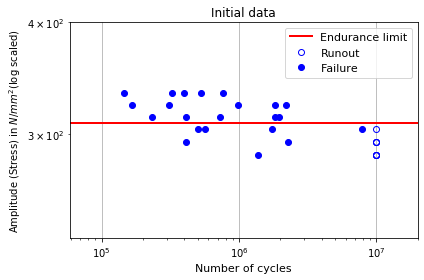

In [7]:
woehler_curve_data_plotter = WoehlerCurveDataPlotter(woehler_curve_creator_options.woehler_curve)

#### 5. Choose the probability curve type to be visualized in the following cell

RadioButtons(description='Plot type', options=('Probability plot of the finite zone', 'Probability plot of the…

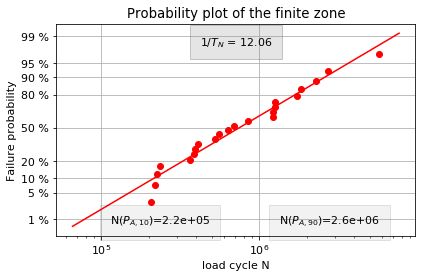

In [8]:
probability_curve_plotter = ProbabilityCurvePlotter(fatigue_data)

### Final Woehler-curve plot
#### 6. Plot of the complete Woehler curve.
#### Choose the value of $k_2$ to plot the figure.

RadioButtons(description='Runout zone plot', options=('k_2 = 0', 'k_2 = k_1', 'k_2 = 2 k_1 - 1'), style=Descri…

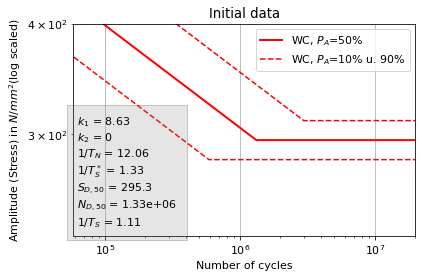

In [9]:
whole_woeler_curve_plotter = WholeWoehlerCurvePlotter(woehler_curve_creator_options.woehler_curve)